In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import datetime as dt
import calendar,warnings,itertools,matplotlib,keras,shutil
import tensorflow as tf
import statsmodels.api as sm
from datetime import datetime
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn import svm,metrics,tree,preprocessing,linear_model
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge,LinearRegression,LogisticRegression,ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor,BaggingClassifier,ExtraTreesClassifier
from sklearn.metrics import accuracy_score,mean_squared_error,recall_score,confusion_matrix,f1_score,roc_curve, auc
from sklearn.datasets import load_iris,make_regression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.kernel_ridge import KernelRidge
from keras import Sequential
from keras.layers import Dense
from IPython.core import display as ICD


#Hiding the warnings
warnings.filterwarnings('ignore') 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset=pd.read_csv("/content/drive/My Drive/suppchaindata.csv",header= 0,encoding= 'unicode_escape')

In [ ]:
dataset.shape

(180519, 53)

In [ ]:
dataset.apply(lambda x: sum(x.isnull())) #Checking missing values

Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0


In [ ]:
# Adding first name and last name together to create new column
dataset['Customer Full Name'] = dataset['Customer Fname'].astype(str)+dataset['Customer Lname'].astype(str)

In [ ]:
data=dataset.drop(['Customer Email','Product Status','Customer Password','Customer Street','Customer Fname','Customer Lname',
           'Latitude','Longitude','Product Description','Product Image','Order Zipcode','shipping date (DateOrders)'],axis=1)
data.shape

(180519, 42)

In [ ]:
data['Customer Zipcode']=data['Customer Zipcode'].fillna(0)#Filling NaN columns with zero

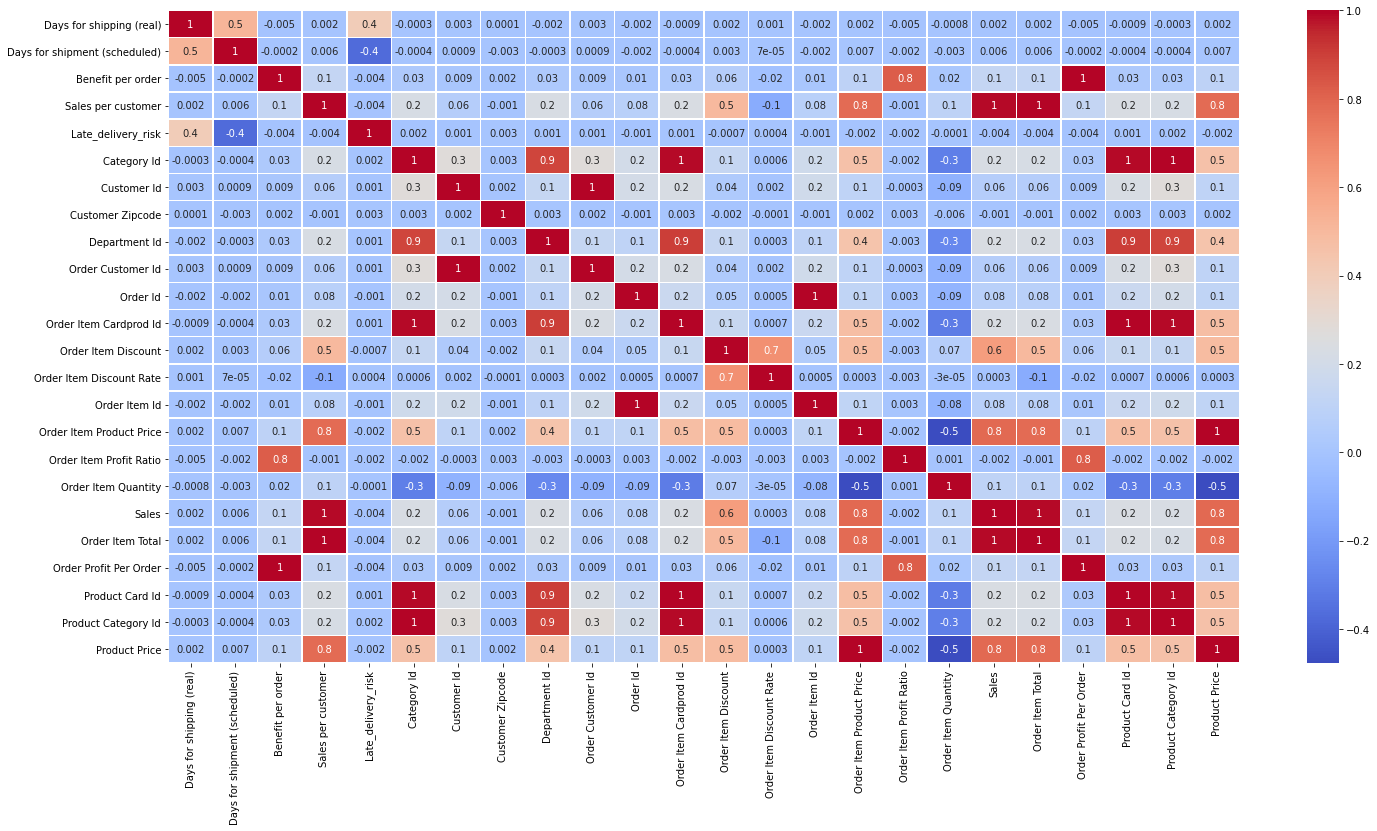

In [ ]:
fig, ax = plt.subplots(figsize=(24,12))         # figsize
sns.heatmap(data.corr(),annot=True,linewidths=.5,fmt='.1g',cmap= 'coolwarm') # Heatmap for correlation matrix

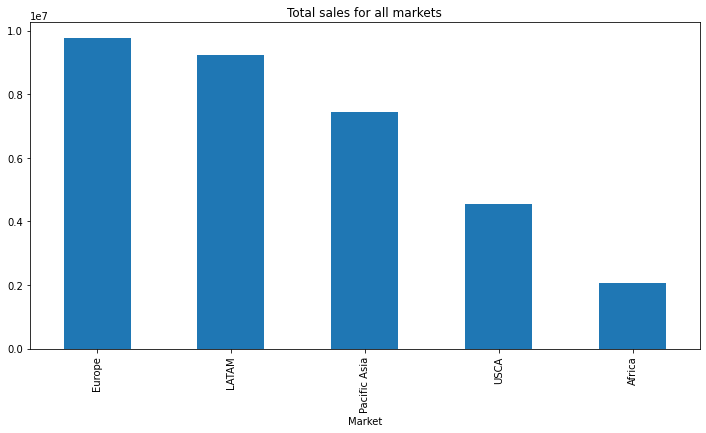

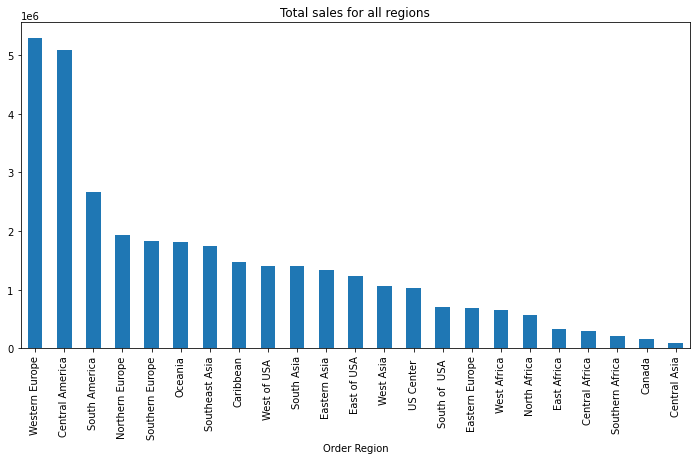

In [ ]:
market = data.groupby('Market') #Grouping by market
region = data.groupby('Order Region')
plt.figure(1)
market['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Total sales for all markets")
plt.figure(2)
region['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Total sales for all regions")

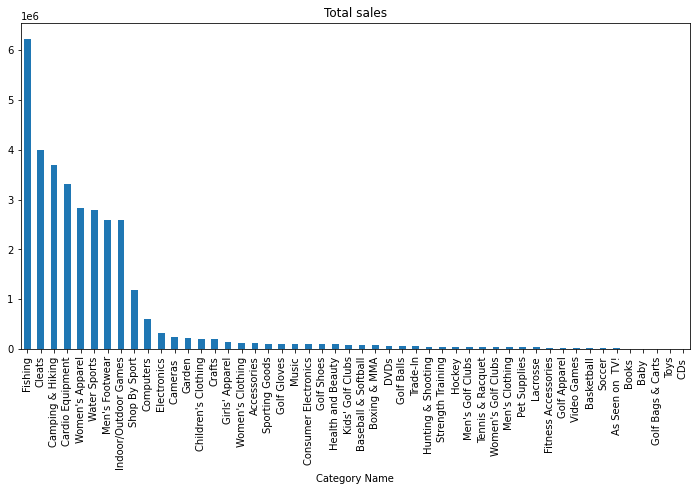

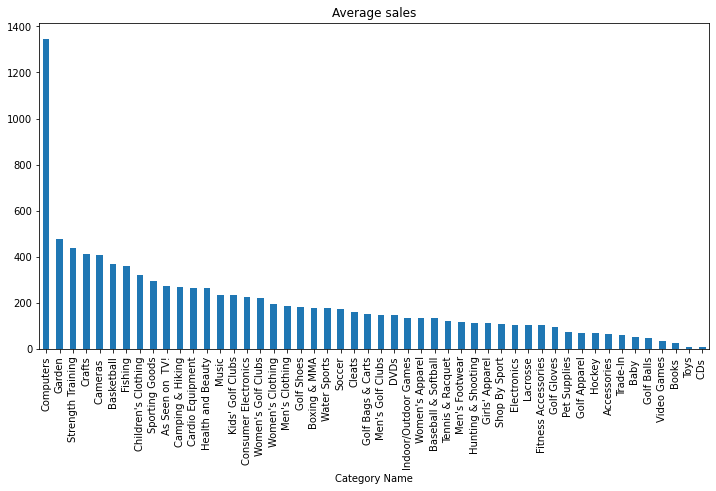

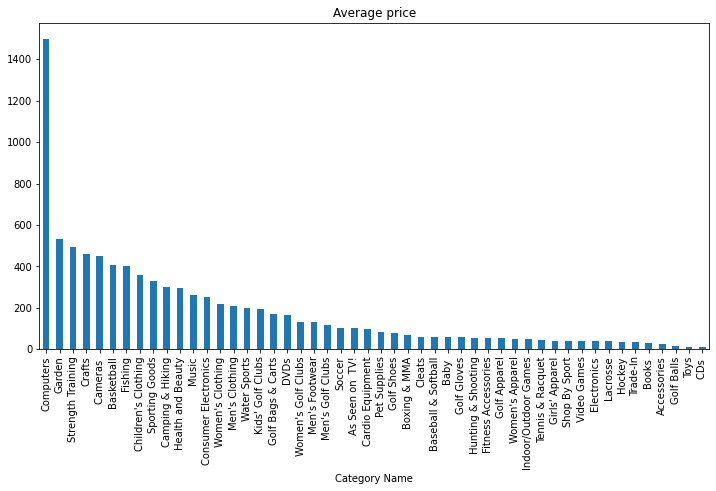

In [ ]:
#Grouping all categories
cat = data.groupby('Category Name')
plt.figure(1)
# Total sum of sales for all categories
cat['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Total sales")
# Mean sales for all categories
plt.figure(2)
cat['Sales per customer'].mean().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Average sales")
plt.figure(3)
# Mean prices for all categories
cat['Product Price'].mean().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Average price")

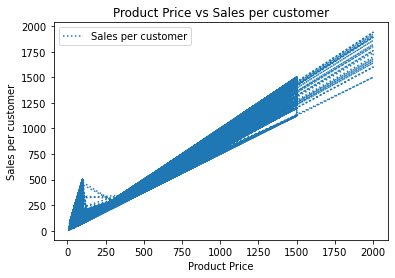

In [ ]:
data.plot(x='Product Price', y='Sales per customer',linestyle='dotted',
     markerfacecolor='blue', markersize=12) 
plt.title('Product Price vs Sales per customer')#title
plt.xlabel('Product Price')  # X-axis title
plt.ylabel('Sales per customer') # Y=axis title
plt.show()

In [ ]:
data['order_year']= pd.DatetimeIndex(data['order date (DateOrders)']).year
data['order_month'] = pd.DatetimeIndex(data['order date (DateOrders)']).month
data['order_week_day'] = pd.DatetimeIndex(data['order date (DateOrders)']).day_name
data['order_hour'] = pd.DatetimeIndex(data['order date (DateOrders)']).hour
data['order_month_year'] = pd.to_datetime(data['order date (DateOrders)']).dt.to_period('M')

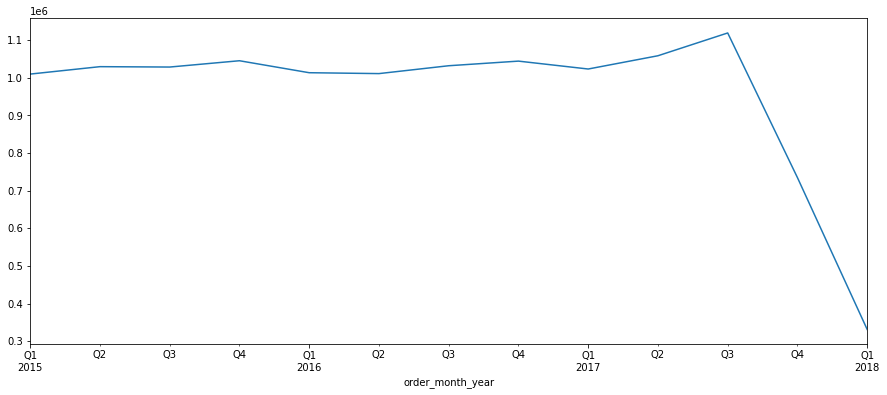

In [ ]:
quater= data.groupby('order_month_year')
quartersales=quater['Sales'].sum().resample('Q').mean().plot(figsize=(15,6))

TypeError: ignored

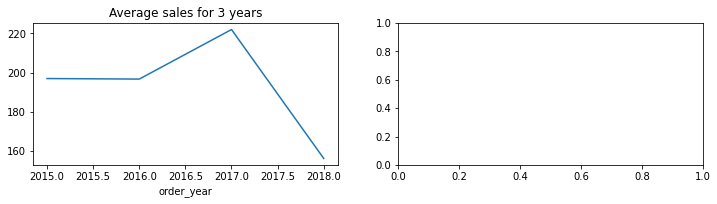

In [ ]:
plt.figure(figsize=(10,12))
plt.subplot(4, 2, 1)
quater= data.groupby('order_year')
quater['Sales'].mean().plot(figsize=(12,12),title='Average sales for 3 years')
plt.subplot(4, 2, 2)
days=data.groupby("order_week_day")
days['Sales'].mean().plot(figsize=(12,12),title='Average sales per week in days')
plt.subplot(4, 2, 3)
hrs=data.groupby("order_hour")
hrs['Sales'].mean().plot(figsize=(12,12),title='Average sales per day in hrs')
plt.subplot(4, 2, 4)
mnth=data.groupby("order_month")
mnth['Sales'].mean().plot(figsize=(12,12),title='Average sales per year in mnths')
plt.tight_layout()
plt.show()

In [ ]:
data['Type'].unique()

array(['DEBIT', 'TRANSFER', 'CASH', 'PAYMENT'], dtype=object)

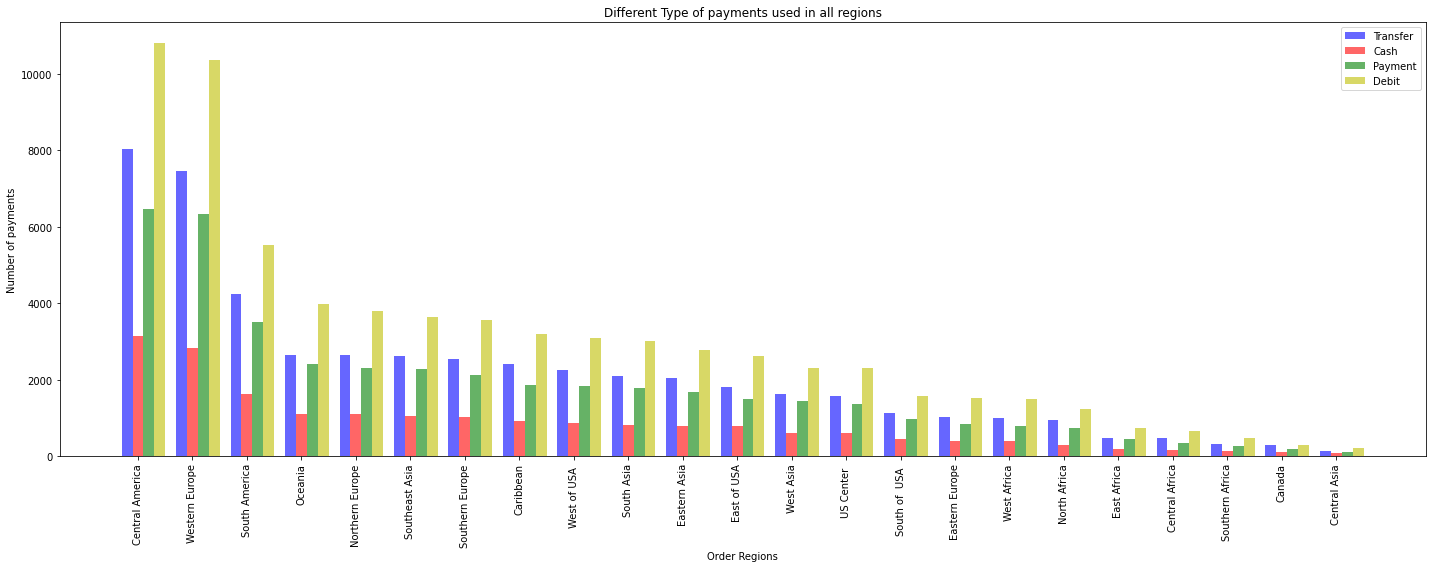

In [ ]:
#xyz = data.groupby('Type')
xyz1 = data[(data['Type'] == 'TRANSFER')]
xyz2= data[(data['Type'] == 'CASH')]
xyz3= data[(data['Type'] == 'PAYMENT')]
xyz4= data[(data['Type'] == 'DEBIT')]
count1=xyz1['Order Region'].value_counts()
count2=xyz2['Order Region'].value_counts()
count3=xyz3['Order Region'].value_counts()
count4=xyz4['Order Region'].value_counts()
names=data['Order Region'].value_counts().keys()
n_groups=23
fig,ax = plt.subplots(figsize=(20,8))
index=np.arange(n_groups)
bar_width=0.2
opacity=0.6
type1=plt.bar(index,count1,bar_width,alpha=opacity,color='b',label='Transfer')
type2=plt.bar(index+bar_width,count2,bar_width,alpha=opacity,color='r',label='Cash')
type3=plt.bar(index+bar_width+bar_width,count3,bar_width,alpha=opacity,color='g',label='Payment')
type4=plt.bar(index+bar_width+bar_width+bar_width,count4,bar_width,alpha=opacity,color='y',label='Debit')
plt.xlabel('Order Regions')
plt.ylabel('Number of payments')
plt.title('Different Type of payments used in all regions')
plt.legend()
plt.xticks(index+bar_width,names,rotation=90)
plt.tight_layout()
plt.show()

Total revenue lost with orders -3883547.345768667


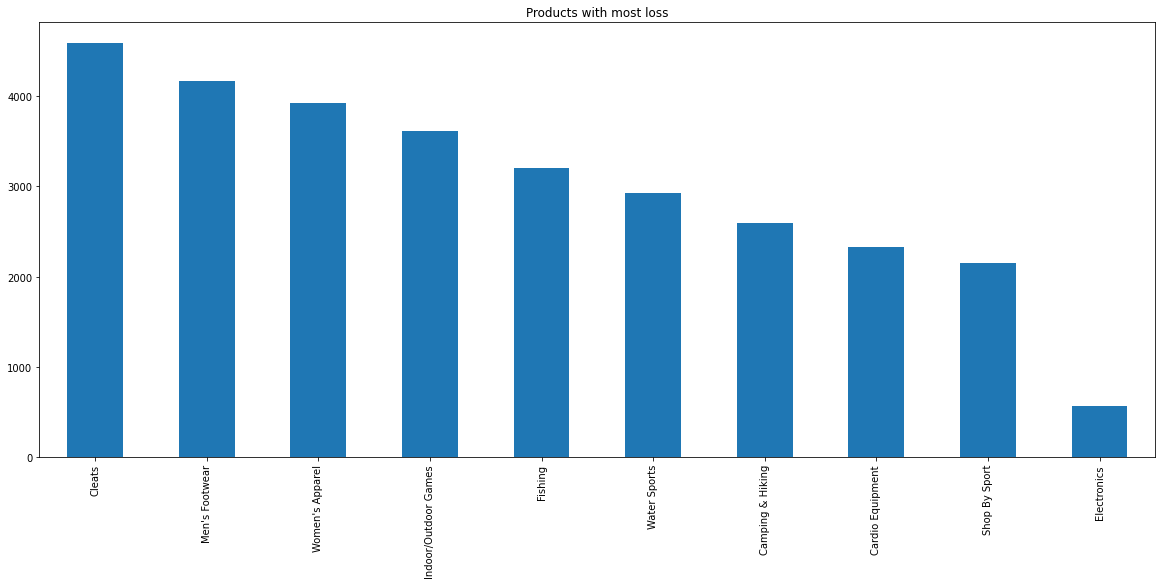

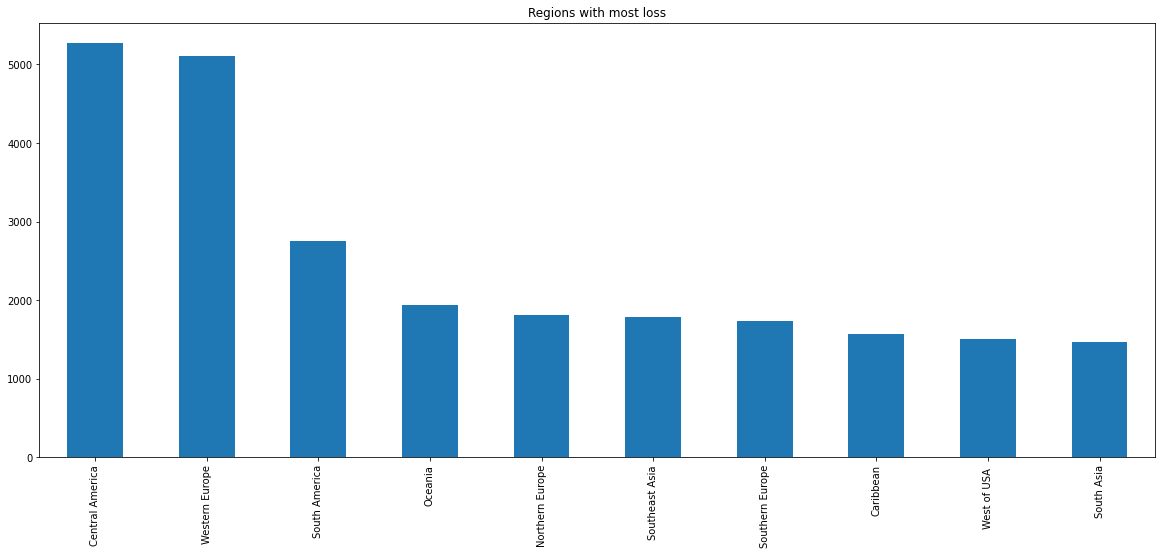

In [ ]:
loss = data[(data['Benefit per order']<0)]
#Plotting top 10 products with most loss
plt.figure(1)
loss['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Products with most loss")
plt.figure(2)
loss['Order Region'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Regions with most loss")
#Sum of total sales which are lost
print('Total revenue lost with orders',loss['Benefit per order'].sum())

In [ ]:
#Checking type of payment used to conduct fraud other than Transfer
xyz = data[(data['Type'] != 'TRANSFER')&(data['Order Status'] == 'SUSPECTED_FRAUD')]
xyz['Order Region'].value_counts()

Series([], Name: Order Region, dtype: int64)

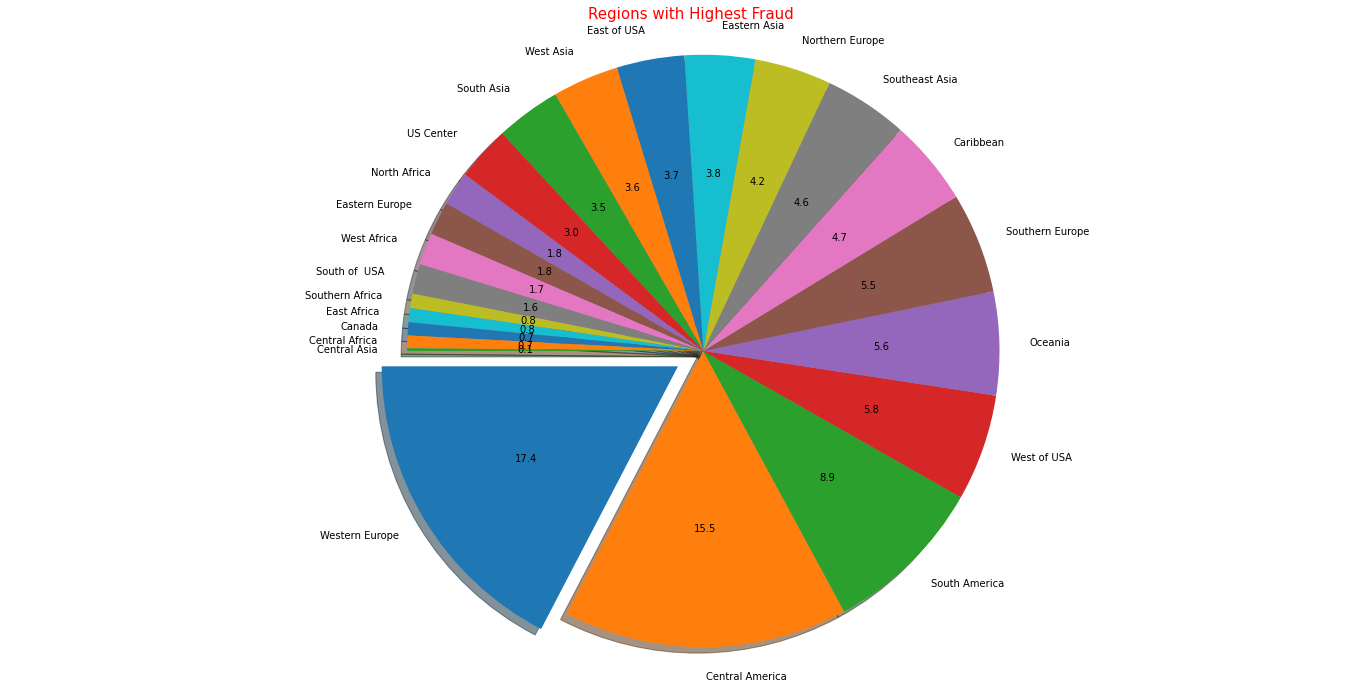

In [ ]:
high_fraud = data[(data['Order Status'] == 'SUSPECTED_FRAUD') & (data['Type'] == 'TRANSFER')]#separating orders with suspected fraud
#Plotting pie chart with respect to order region
fraud=high_fraud['Order Region'].value_counts().plot.pie(figsize=(24,12),
                                                  startangle=180, explode=(0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0),autopct='%.1f',shadow=True,)
plt.title("Regions with Highest Fraud",size=15,color='r') # Plotting title
plt.ylabel(" ")
fraud.axis('equal') 
plt.show()

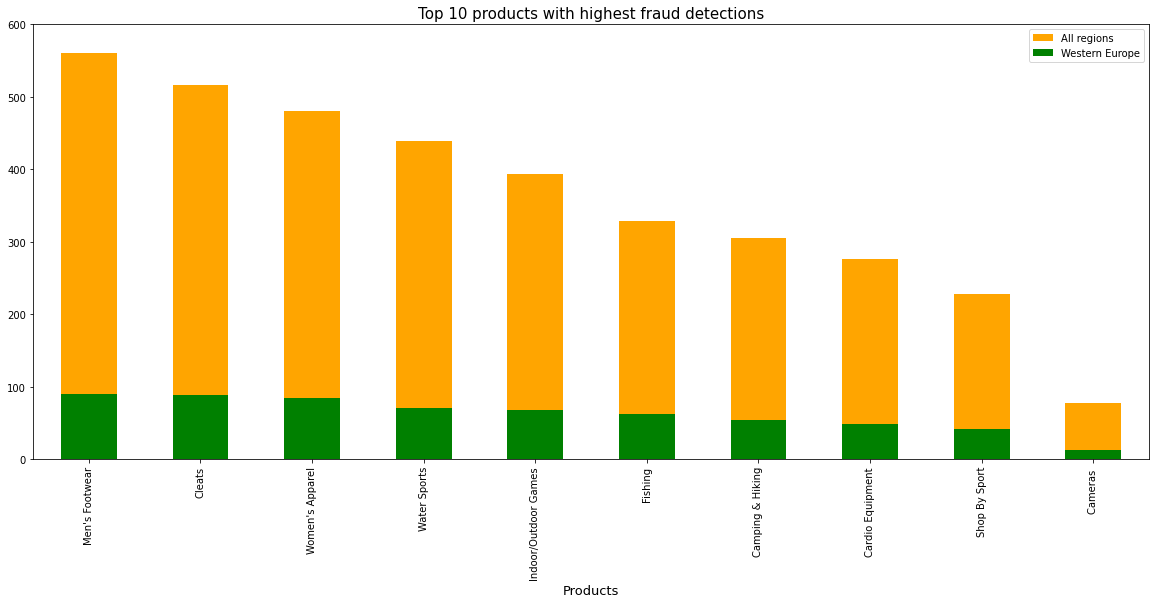

In [ ]:
high_fraud1 = data[(data['Order Status'] == 'SUSPECTED_FRAUD')] # 
high_fraud2 = data[(data['Order Status'] == 'SUSPECTED_FRAUD') &(data['Order Region'] == 'Western Europe')]
#Plotting bar chart for top 10 most suspected fraud department in all regions
fraud1=high_fraud1['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Fraud Category",color='orange')
#Plotting bar chart for top 10 most suspected fraud department in Western Europe
fraud2=high_fraud2['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Fraud product in Western Europe",color='green')
plt.legend(["All regions", "Western Europe"])
plt.title("Top 10 products with highest fraud detections", size=15)
plt.xlabel("Products", size=13)
plt.ylim(0,600)
plt.show()

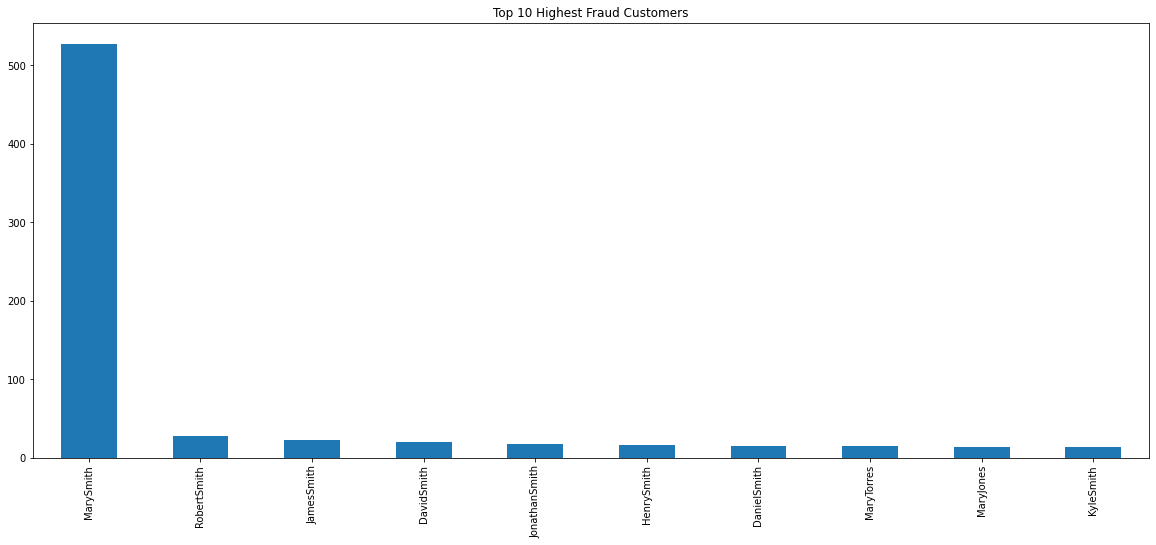

In [ ]:
#Filtering out suspected fruad orders
cus = data[(data['Order Status'] == 'SUSPECTED_FRAUD')] 
#Top 10 customers with most fraud
cus['Customer Full Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Top 10 Highest Fraud Customers")

In [ ]:
#Filtering orders of mary smith with suspected fraud
amount = data[(data['Customer Full Name'] == 'MarySmith')&(data['Order Status'] == 'SUSPECTED_FRAUD')]
#Plotting bar chart for top 10 most suspected fraud customers
amount['Sales'].sum()

102491.66191043999

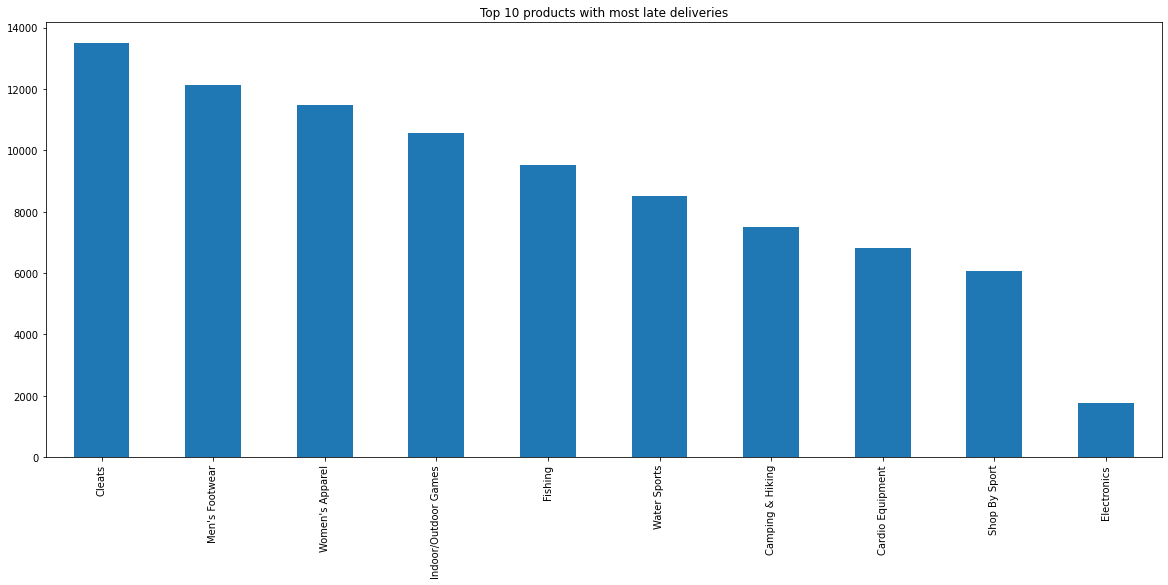

In [ ]:
#Filtering columns with late delivery status
late_delivery = data[(data['Delivery Status'] == 'Late delivery')]
#Top 10 products with most late deliveries
late_delivery['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Top 10 products with most late deliveries")

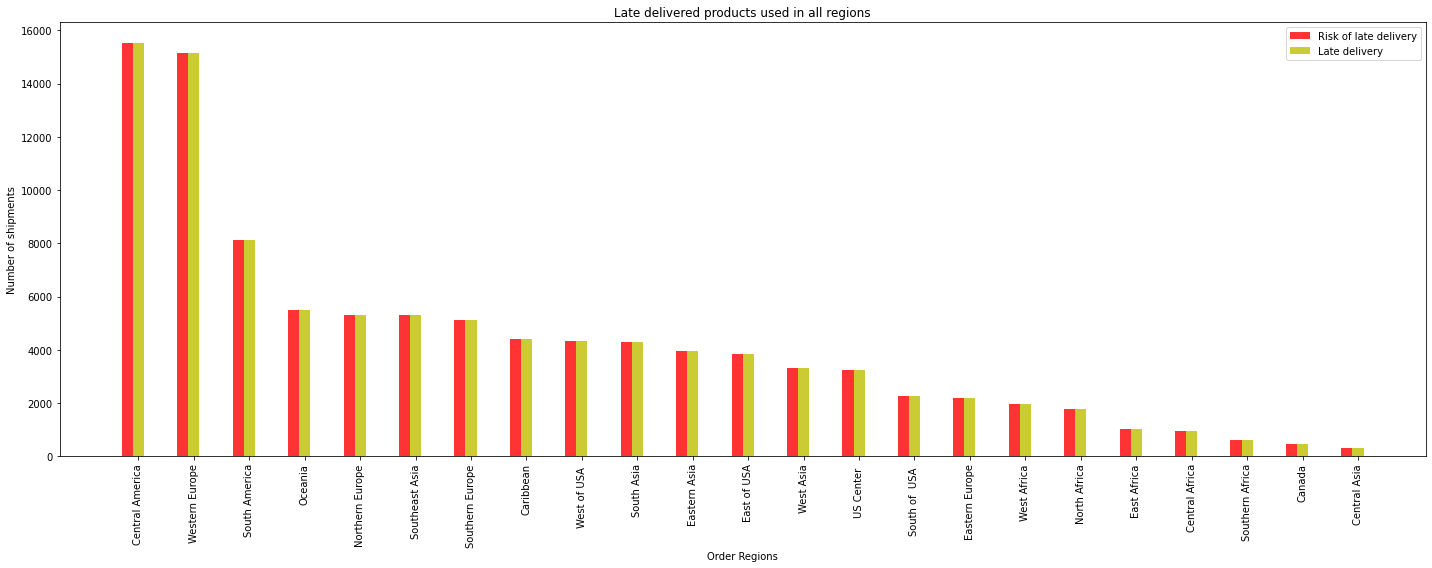

In [ ]:
#Filtering orders with late delivery risk
xyz1 = data[(data['Late_delivery_risk'] == 1)]
#Filtering late delivered orders
xyz2 = data[(data['Delivery Status'] == 'Late delivery')]
count1=xyz1['Order Region'].value_counts()
count2=xyz2['Order Region'].value_counts()
#Index names
names=data['Order Region'].value_counts().keys()
n_groups=23
fig,ax = plt.subplots(figsize=(20,8)) #Figure size
index=np.arange(n_groups)
bar_width=0.2
opacity=0.8
type1=plt.bar(index,count1,bar_width,alpha=opacity,color='r',label='Risk of late delivery')
type2=plt.bar(index+bar_width,count2,bar_width,alpha=opacity,color='y',label='Late delivery')
plt.xlabel('Order Regions')
plt.ylabel('Number of shipments')
plt.title('Late delivered products used in all regions')
plt.legend()
plt.xticks(index+bar_width,names,rotation=90)
plt.tight_layout()
plt.show()

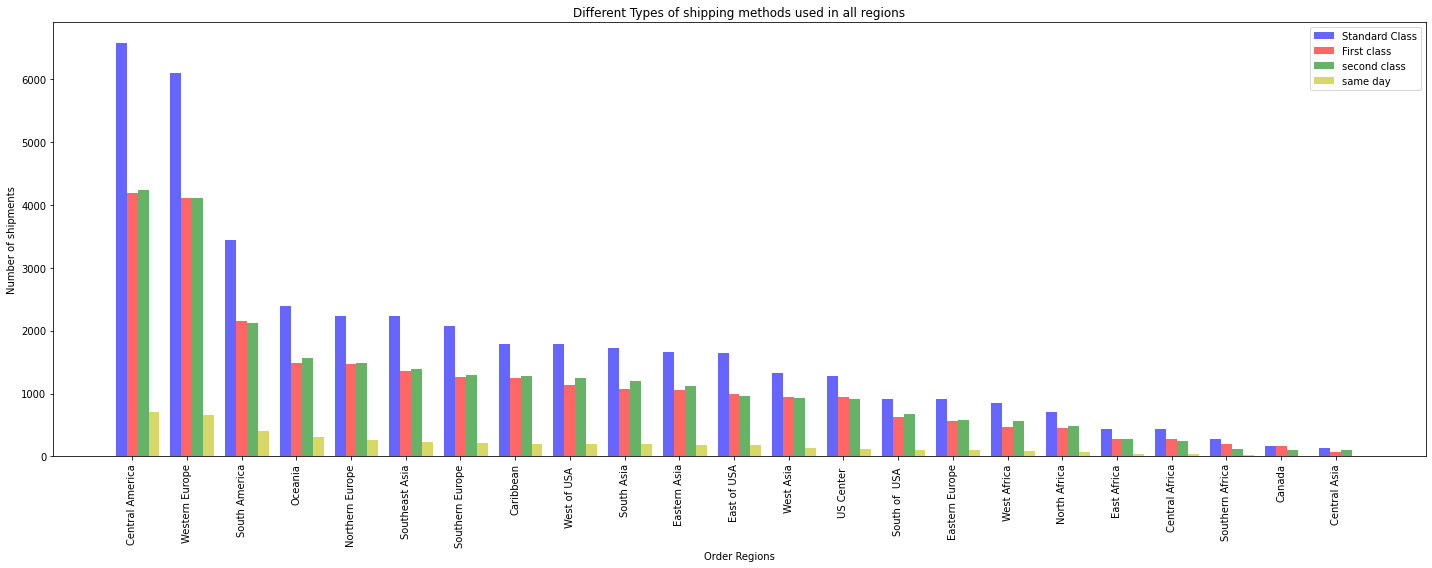

In [ ]:
#Filtering late delivery orders with standard class shipping
xyz1 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'Standard Class')]
#Filtering late delivery orders with first class shipping
xyz2 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'First Class')]
#Filtering late delivery orders with second class shipping
xyz3 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'Second Class')]
#Filtering late delivery orders with same day shipping
xyz4 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'Same Day')]
#Counting total values
count1=xyz1['Order Region'].value_counts()
count2=xyz2['Order Region'].value_counts()
count3=xyz3['Order Region'].value_counts()
count4=xyz4['Order Region'].value_counts()
#Index names
names=data['Order Region'].value_counts().keys()
n_groups=23
fig,ax = plt.subplots(figsize=(20,8))
index=np.arange(n_groups)
bar_width=0.2
opacity=0.6
type1=plt.bar(index,count1,bar_width,alpha=opacity,color='b',label='Standard Class')
type2=plt.bar(index+bar_width,count2,bar_width,alpha=opacity,color='r',label='First class')
type3=plt.bar(index+bar_width+bar_width,count3,bar_width,alpha=opacity,color='g',label='second class')
type4=plt.bar(index+bar_width+bar_width+bar_width,count4,bar_width,alpha=opacity,color='y',label='same day')
plt.xlabel('Order Regions')
plt.ylabel('Number of shipments')
plt.title('Different Types of shipping methods used in all regions')
plt.legend()
plt.xticks(index+bar_width,names,rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
#Calculating total price for which each order
data['TotalPrice'] = data['Order Item Quantity'] * data['Order Item Total']# Multiplying item price * Order quantity

In [ ]:
data['order date (DateOrders)'].max() # Calculating when the last order come to check recency

'9/9/2017 9:50'

In [ ]:
#Present date was set to next day of the last order. i.e,2018-02-01
present = dt.datetime(2018,2,1)
data['order date (DateOrders)'] = pd.to_datetime(data['order date (DateOrders)'])

In [ ]:
# Grouping all values into new data frame named customer segmentation
Customer_seg = data.groupby('Order Customer Id').agg({'order date (DateOrders)': lambda x: (present - x.max()).days, 'Order Id': lambda x: len(x), 'TotalPrice': lambda x: x.sum()})
#Changing order dates to int format
Customer_seg['order date (DateOrders)'] = Customer_seg['order date (DateOrders)'].astype(int)
# Renaming columns as R_Value,F_Value,M_Value
Customer_seg.rename(columns={'order date (DateOrders)': 'R_Value', 
                         'Order Id': 'F_Value', 
                         'TotalPrice': 'M_Value'}, inplace=True)
Customer_seg.head()

,R_Value,F_Value,M_Value
Order Customer Id,,,
1,792,1,2362.250061
2,136,10,2842.700073
3,229,18,6143.760057
4,380,14,4370.629991
5,457,7,2993.790032


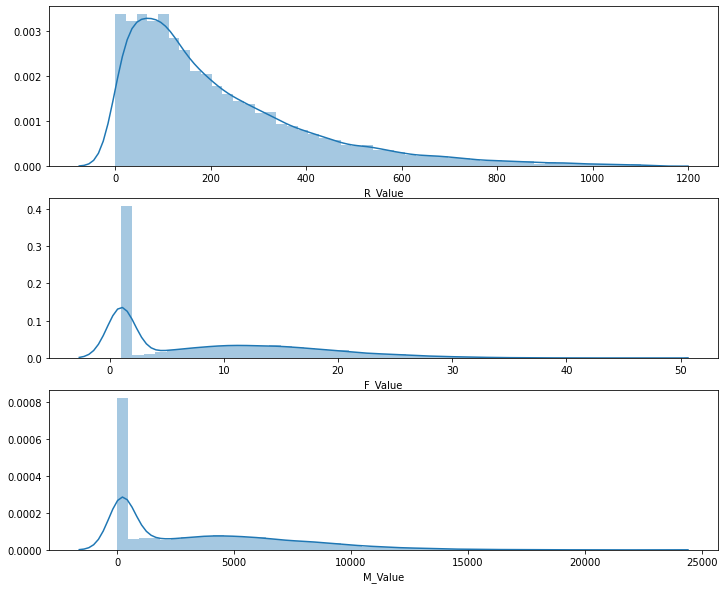

In [ ]:
plt.figure(figsize=(12,10)) # Figure size
plt.subplot(3, 1, 1)
sns.distplot(Customer_seg['R_Value'])# Plot distribution of R_Value
plt.subplot(3, 1, 2) 
sns.distplot(Customer_seg['F_Value'])# Plot distribution of F_Value
plt.subplot(3, 1, 3)
sns.distplot(Customer_seg['M_Value'])# Plot distribution of M_Value
plt.show()

In [ ]:
quantiles = Customer_seg.quantile(q=[0.25,0.5,0.75]) #Dividing RFM data into four quartiles
quantiles = quantiles.to_dict() 

In [ ]:
# R_Score should be minimum so 1st quantile is set as 1.
def R_Score(a,b,c):
    if a <= c[b][0.25]:
        return 1
    elif a <= c[b][0.50]:
        return 2
    elif a <= c[b][0.75]: 
        return 3
    else:
        return 4
# The higher the F_Score,M_Score the better so 1st quantile is set as 4.    
def FM_Score(x,y,z):
    if x <= z[y][0.25]:
        return 4
    elif x <= z[y][0.50]:
        return 3
    elif x <= z[y][0.75]: 
        return 2
    else:
        return 1

In [ ]:
# New column for R_Score to indicate numerical score between 1 to 4.
Customer_seg['R_Score'] = Customer_seg['R_Value'].apply(R_Score, args=('R_Value',quantiles))
# New column for F_Score to indicate numerical score between 1 to 4.
Customer_seg['F_Score'] = Customer_seg['F_Value'].apply(FM_Score, args=('F_Value',quantiles))
# New column for M_Score to indicate numerical score between 1 to 4.
Customer_seg['M_Score'] = Customer_seg['M_Value'].apply(FM_Score, args=('M_Value',quantiles))
Customer_seg.head()

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score
Order Customer Id,,,,,,
1,792,1,2362.250061,4,4,3
2,136,10,2842.700073,2,2,2
3,229,18,6143.760057,3,1,1
4,380,14,4370.629991,4,2,2
5,457,7,2993.790032,4,3,2


In [ ]:
#Adding R,F,M Scores to one new column
Customer_seg['RFM_Score'] = Customer_seg.R_Score.astype(str)+ Customer_seg.F_Score.astype(str) + Customer_seg.M_Score.astype(str)
Customer_seg.head()

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,RFM_Score
Order Customer Id,,,,,,,
1,792,1,2362.250061,4,4,3,443
2,136,10,2842.700073,2,2,2,222
3,229,18,6143.760057,3,1,1,311
4,380,14,4370.629991,4,2,2,422
5,457,7,2993.790032,4,3,2,432


In [ ]:
count=Customer_seg['RFM_Score'].unique()
print(count)# Printing all Unique values
len(count)# Total count

['443' '222' '311' '422' '432' '421' '211' '322' '434' '212' '411' '331'
 '412' '433' '321' '423' '333' '312' '221' '223' '332' '233' '232' '323'
 '444' '431' '343' '243' '344' '334' '244' '143' '144']


33

In [ ]:
# Calculate RFM_Score
Customer_seg['RFM_Total_Score'] = Customer_seg[['R_Score','F_Score','M_Score']].sum(axis=1)
Customer_seg['RFM_Total_Score'].unique()

array([11,  6,  5,  8,  9,  7,  4, 10, 12])

In [ ]:
# Define rfm_level function
def RFM_Total_Score(df):

    if (df['RFM_Total_Score'] >= 11):# For RFM score with values 11,12
        return 'Champions' 
    elif (df['RFM_Total_Score'] == 10):# For RFM score with value 10
        return 'Loyal Customers' 
    elif (df['RFM_Total_Score'] == 9): # For RFM score with value 9
        return 'Recent Customers'
    elif (df['RFM_Total_Score'] == 8): # For RFM score with value 8
         return 'Promising'
    elif (df['RFM_Total_Score'] == 7): # For RFM score with value 7
        return 'Customers Needing Attention'
    elif (df['RFM_Total_Score'] == 6): # For RFM score with value 6
        return 'Cant lose them'
    elif (df['RFM_Total_Score'] == 5): # For RFM score with value 5
        return 'At Risk'
    else:                               # For RFM score with value less than 5
        
        return 'Lost'
# Create a new variable RFM_Level
Customer_seg['Customer_Segmentation'] =Customer_seg.apply(RFM_Total_Score, axis=1)
# Print the header with top 5 rows to the console
Customer_seg.head()

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,RFM_Score,RFM_Total_Score,Customer_Segmentation
Order Customer Id,,,,,,,,,
1,792,1,2362.250061,4,4,3,443,11,Champions
2,136,10,2842.700073,2,2,2,222,6,Cant lose them
3,229,18,6143.760057,3,1,1,311,5,At Risk
4,380,14,4370.629991,4,2,2,422,8,Promising
5,457,7,2993.790032,4,3,2,432,9,Recent Customers


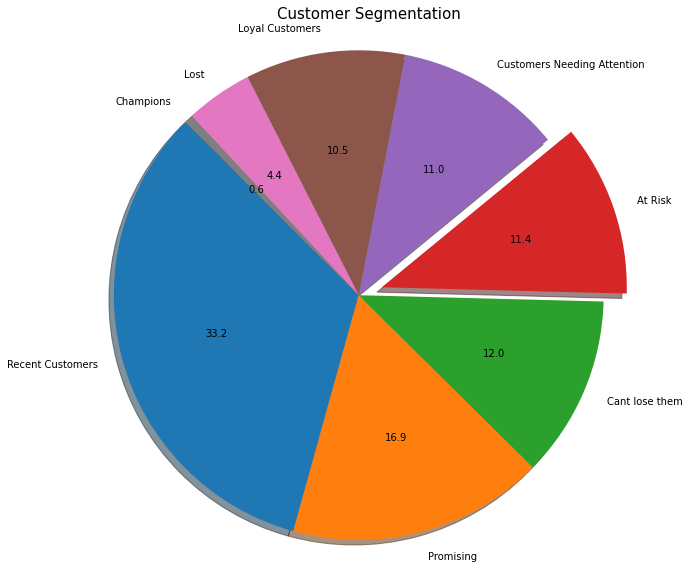

In [ ]:
# Calculate average values for each RFM_Level, and return a size of each segment 
Customer_seg['Customer_Segmentation'].value_counts().plot.pie(figsize=(10,10),
                                        startangle=135, explode=(0,0,0,0.1,0,0,0,0),autopct='%.1f',shadow=True)
plt.title("Customer Segmentation",size=15)
plt.ylabel(" ")
plt.axis('equal') 
plt.show()

In [ ]:
churned=Customer_seg[(Customer_seg['RFM_Score']=='411')].sort_values('M_Value', ascending=False).head(10)
churned

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,RFM_Score,RFM_Total_Score,Customer_Segmentation
Order Customer Id,,,,,,,,,
11065,309,41,18641.300091,4,1,1,411,6,Cant lose them
6285,332,37,18287.010097,4,1,1,411,6,Cant lose them
7892,392,29,17620.470196,4,1,1,411,6,Cant lose them
2893,312,24,17536.609842,4,1,1,411,6,Cant lose them
4181,425,29,17333.960094,4,1,1,411,6,Cant lose them
4781,502,31,17048.380088,4,1,1,411,6,Cant lose them
9271,344,35,17044.910217,4,1,1,411,6,Cant lose them
4659,417,27,16973.060024,4,1,1,411,6,Cant lose them
1695,326,33,16916.020176,4,1,1,411,6,Cant lose them


In [ ]:
#The R_Score should be low and F_Score, M_Score should be as high as possible
Customer_seg[(Customer_seg['RFM_Score']=='144')|(Customer_seg['RFM_Score']=='143')].sort_values('M_Value', ascending=False).head(10)

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,RFM_Score,RFM_Total_Score,Customer_Segmentation
Order Customer Id,,,,,,,,,
18101,38,1,1500.0,1,4,3,143,8,Promising
18083,39,1,1500.0,1,4,3,143,8,Promising
18047,39,1,1500.0,1,4,3,143,8,Promising
18065,39,1,1500.0,1,4,3,143,8,Promising
18119,38,1,1500.0,1,4,3,143,8,Promising
18046,39,1,1485.0,1,4,3,143,8,Promising
18100,38,1,1485.0,1,4,3,143,8,Promising
18118,38,1,1485.0,1,4,3,143,8,Promising
18064,39,1,1485.0,1,4,3,143,8,Promising


DATA modellling

In [ ]:
train_data=data.copy()

In [ ]:
train_data['fraud'] = np.where(train_data['Order Status'] == 'SUSPECTED_FRAUD', 1, 0)
train_data['late_delivery']=np.where(train_data['Delivery Status'] == 'Late delivery', 1, 0)

In [ ]:
#Dropping columns with repeated values
train_data.drop(['Delivery Status','Late_delivery_risk','Order Status','order_month_year','order date (DateOrders)'], axis=1, inplace=True)

In [ ]:
train_data.dtypes

Type                              object
Days for shipping (real)           int64
Days for shipment (scheduled)      int64
Benefit per order                float64
Sales per customer               float64
Category Id                        int64
Category Name                     object
Customer City                     object
Customer Country                  object
Customer Id                        int64
Customer Segment                  object
Customer State                    object
Customer Zipcode                 float64
Department Id                      int64
Department Name                   object
Market                            object
Order City                        object
Order Country                     object
Order Customer Id                  int64
Order Id                           int64
Order Item Cardprod Id             int64
Order Item Discount              float64
Order Item Discount Rate         float64
Order Item Id                      int64
Order Item Produ

In [ ]:
# create the Labelencoder object
le = preprocessing.LabelEncoder()
#convert the categorical columns into numeric
train_data['Customer Country']  = le.fit_transform(train_data['Customer Country'])
train_data['Market']            = le.fit_transform(train_data['Market'])
train_data['Type']              = le.fit_transform(train_data['Type'])
train_data['Product Name']      = le.fit_transform(train_data['Product Name'])
train_data['Customer Segment']  = le.fit_transform(train_data['Customer Segment'])
train_data['Customer State']    = le.fit_transform(train_data['Customer State'])
train_data['Order Region']      = le.fit_transform(train_data['Order Region'])
train_data['Order City']        = le.fit_transform(train_data['Order City'])
train_data['Category Name']     = le.fit_transform(train_data['Category Name'])
train_data['Customer City']     = le.fit_transform(train_data['Customer City'])
train_data['Department Name']   = le.fit_transform(train_data['Department Name'])
train_data['Order State']       = le.fit_transform(train_data['Order State'])
train_data['Shipping Mode']     = le.fit_transform(train_data['Shipping Mode'])
train_data['Order Country']     = le.fit_transform(train_data['Order Country'])
train_data['Customer Full Name']= le.fit_transform(train_data['Customer Full Name'])

#display the initial records
train_data.head()


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Category Id,Category Name,Customer City,Customer Country,Customer Id,Customer Segment,Customer State,Customer Zipcode,Department Id,Department Name,Market,Order City,Order Country,Order Customer Id,Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Product Card Id,Product Category Id,Product Name,Product Price,Shipping Mode,Customer Full Name,order_year,order_month,order_week_day,order_hour,TotalPrice,fraud,late_delivery
0,1,3,4,91.250000,314.640015,73,40,66,1,20755,0,36,725.0,2,4,3,331,70,20755,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,15,475,1360,73,78,327.75,3,1876,2018,1,<bound method PandasDelegate._add_delegate_acc...,22,314.640015,0,0
1,3,5,4,-249.089996,311.359985,73,40,66,1,19492,0,36,725.0,2,4,3,391,69,19492,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,13,841,1360,73,78,327.75,3,5378,2018,1,<bound method PandasDelegate._add_delegate_acc...,12,311.359985,0,1
2,0,4,4,-247.779999,309.720001,73,40,452,0,19491,0,5,95125.0,2,4,3,391,69,19491,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,13,841,1360,73,78,327.75,3,4429,2018,1,<bound method PandasDelegate._add_delegate_acc...,12,309.720001,0,0
3,1,3,4,22.860001,304.809998,73,40,285,0,19490,2,5,90027.0,2,4,3,3226,8,19490,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,11,835,1360,73,78,327.75,3,12929,2018,1,<bound method PandasDelegate._add_delegate_acc...,11,304.809998,0,0
4,2,2,4,134.210007,298.250000,73,40,66,1,19489,1,36,725.0,2,4,3,3226,8,19489,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,11,835,1360,73,78,327.75,3,10638,2018,1,<bound method PandasDelegate._add_delegate_acc...,11,298.250000,0,0


In [ ]:
train_data=train_data.drop(['order_week_day'], axis=1)

In [ ]:
train_data.shape

(180519, 44)

In [ ]:
#All columns expect fraud
xf=train_data.loc[:, train_data.columns != 'fraud']
#Only fraud column
yf=train_data['fraud']
#Splitting the data into two parts in which 80% data will be used for training the model and 20% for testing
xf_train, xf_test,yf_train,yf_test = train_test_split(xf,yf,test_size = 0.2,random_state = 42)
#All columns expect fraud
xl=train_data.loc[:, train_data.columns != 'late_delivery']
#Only fraud column
yl=train_data['late_delivery']
#Splitting the data into two parts in which 80% data will be used for training the model and 20% for testing
xl_train, xl_test,yl_train,yl_test = train_test_split(xl,yl,test_size = 0.2, random_state = 42)

In [ ]:
sc = StandardScaler()
xf_train=sc.fit_transform(xf_train)
xf_test=sc.transform(xf_test)
xl_train=sc.fit_transform(xl_train)
xl_test=sc.transform(xl_test)

In [ ]:
xf_train.shape

(144415, 43)

Feature selection for fraud

In [ ]:
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Define dictionary to store our rankings
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [ ]:
xf_train.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Category Id',
       'Category Name', 'Customer City', 'Customer Country', 'Customer Id',
       'Customer Segment', 'Customer State', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Market', 'Order City',
       'Order Country', 'Order Customer Id', 'Order Id',
       'Order Item Cardprod Id', 'Order Item Discount',
       'Order Item Discount Rate', 'Order Item Id', 'Order Item Product Price',
       'Order Item Profit Ratio', 'Order Item Quantity', 'Sales',
       'Order Item Total', 'Order Profit Per Order', 'Order Region',
       'Order State', 'Product Card Id', 'Product Category Id', 'Product Name',
       'Product Price', 'Shipping Mode', 'Customer Full Name', 'order_year',
       'order_month', 'order_hour', 'TotalPrice', 'late_delivery'],
      dtype='object')

In [ ]:
feature_cols_f=['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Category Id',
       'Category Name', 'Customer City', 'Customer Country', 'Customer Id',
       'Customer Segment', 'Customer State', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Market', 'Order City',
       'Order Country', 'Order Customer Id', 'Order Id',
       'Order Item Cardprod Id', 'Order Item Discount',
       'Order Item Discount Rate', 'Order Item Id', 'Order Item Product Price',
       'Order Item Profit Ratio', 'Order Item Quantity', 'Sales',
       'Order Item Total', 'Order Profit Per Order', 'Order Region',
       'Order State', 'Product Card Id', 'Product Category Id', 'Product Name',
       'Product Price', 'Shipping Mode', 'Customer Full Name', 'order_year',
       'order_month', 'order_hour', 'TotalPrice', 'late_delivery']

In [ ]:
dept_cols_f=['fraud']

In [ ]:
# Construct our Linear Regression model
lr = LinearRegression(normalize=True)
lr.fit(xf,yf)
#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=1, verbose =3 )
rfe.fit(xf,yf)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), feature_cols_f, order=-1)

Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 fe

In [ ]:
# Using Linear Regression
lr = LinearRegression(normalize=True)
lr.fit(xf,yf)
ranks["LinReg"] = ranking(np.abs(lr.coef_), feature_cols_f)

# Using Ridge 
ridge = Ridge(alpha = 7)
ridge.fit(xf,yf)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), feature_cols_f)

# Using Lasso
lasso = Lasso(alpha=.05)
lasso.fit(xf, yf)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), feature_cols_f)

In [ ]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=3)
rf.fit(xf,yf)
ranks["RF"] = ranking(rf.feature_importances_, feature_cols_f);

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.7s


building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.0s finished


In [ ]:
# Create empty dictionary to store the mean value calculated from all the scores
r = {}
for name in feature_cols_f:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print("\t                %s" % "\t".join(methods))
for name in feature_cols_f:
    print("%s        \t       %s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))

	                Lasso	LinReg	RF	RFE	Ridge	Mean
Type        	       0.0	0.13	0.5	0.83	0.17	0.33
Days for shipping (real)        	       0.0	0.19	1.0	0.86	0.26	0.46
Days for shipment (scheduled)        	       0.0	0.06	0.03	0.81	0.08	0.2
Benefit per order        	       0.0	0.0	0.06	0.24	0.0	0.06
Sales per customer        	       0.0	0.5	0.04	0.95	0.02	0.3
Category Id        	       0.0	0.0	0.01	0.48	0.0	0.1
Category Name        	       0.0	0.0	0.03	0.52	0.0	0.11
Customer City        	       0.0	0.0	0.3	0.29	0.0	0.12
Customer Country        	       0.0	0.01	0.0	0.76	0.01	0.16
Customer Id        	       0.21	0.0	0.31	0.12	0.0	0.13
Customer Segment        	       0.0	0.01	0.09	0.74	0.01	0.17
Customer State        	       0.0	0.0	0.15	0.5	0.0	0.13
Customer Zipcode        	       0.01	0.0	0.3	0.0	0.0	0.06
Department Id        	       0.0	0.0	0.0	0.38	0.0	0.08
Department Name        	       0.0	0.0	0.01	0.55	0.0	0.11
Market        	       0.0	0.0	0.07	0.57	0.0	0.13
Order City        	       

In [ ]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)

Feature ranking for fraud

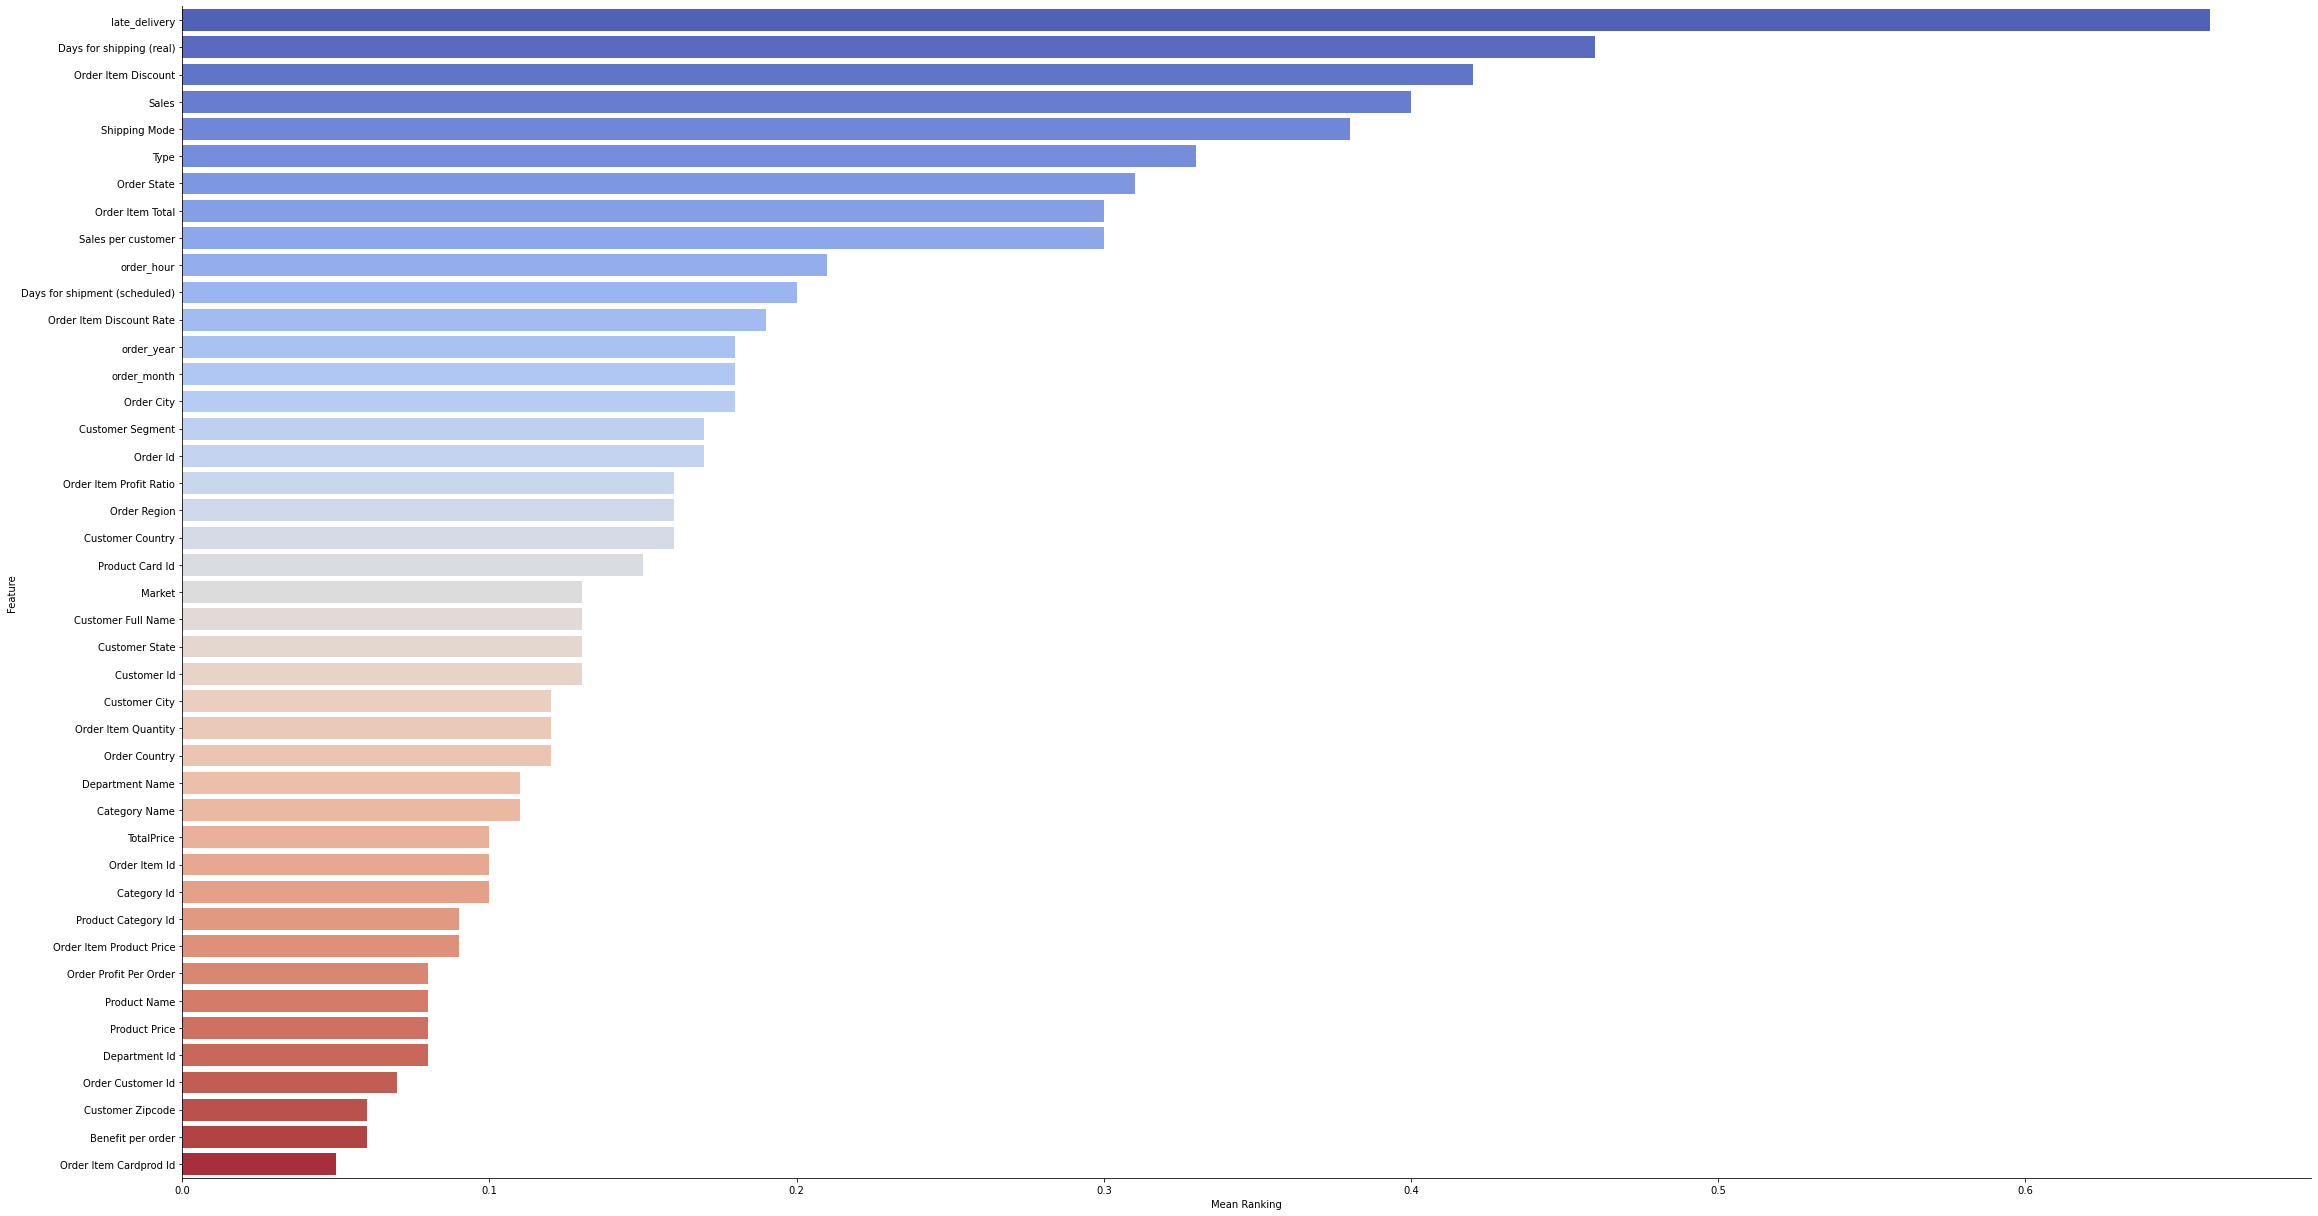

In [ ]:
# Let's plot the ranking of the features
sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", 
               size=17, aspect=1.9, palette='coolwarm')

Feature selection for late_delivery

In [ ]:
xl.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Category Id',
       'Category Name', 'Customer City', 'Customer Country', 'Customer Id',
       'Customer Segment', 'Customer State', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Market', 'Order City',
       'Order Country', 'Order Customer Id', 'Order Id',
       'Order Item Cardprod Id', 'Order Item Discount',
       'Order Item Discount Rate', 'Order Item Id', 'Order Item Product Price',
       'Order Item Profit Ratio', 'Order Item Quantity', 'Sales',
       'Order Item Total', 'Order Profit Per Order', 'Order Region',
       'Order State', 'Product Card Id', 'Product Category Id', 'Product Name',
       'Product Price', 'Shipping Mode', 'Customer Full Name', 'order_year',
       'order_month', 'order_hour', 'TotalPrice', 'fraud'],
      dtype='object')

In [ ]:
feature_cols_l=['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Category Id',
       'Category Name', 'Customer City', 'Customer Country', 'Customer Id',
       'Customer Segment', 'Customer State', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Market', 'Order City',
       'Order Country', 'Order Customer Id', 'Order Id',
       'Order Item Cardprod Id', 'Order Item Discount',
       'Order Item Discount Rate', 'Order Item Id', 'Order Item Product Price',
       'Order Item Profit Ratio', 'Order Item Quantity', 'Sales',
       'Order Item Total', 'Order Profit Per Order', 'Order Region',
       'Order State', 'Product Card Id', 'Product Category Id', 'Product Name',
       'Product Price', 'Shipping Mode', 'Customer Full Name', 'order_year',
       'order_month', 'order_hour', 'TotalPrice', 'fraud']

In [ ]:
dept_cols_l=['late_delivery']

In [ ]:
# Construct our Linear Regression model
lr = LinearRegression(normalize=True)
lr.fit(xl,yl)
#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=1, verbose =3 )
rfe.fit(xl,yl)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), feature_cols_l, order=-1)

Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 fe

In [ ]:
# Using Linear Regression
lr = LinearRegression(normalize=True)
lr.fit(xl,yl)
ranks["LinReg"] = ranking(np.abs(lr.coef_), feature_cols_l)

# Using Ridge 
ridge = Ridge(alpha = 7)
ridge.fit(xl,yl)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), feature_cols_l)

# Using Lasso
lasso = Lasso(alpha=.05)
lasso.fit(xl, yl)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), feature_cols_l)

In [ ]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=3)
rf.fit(xl,yl)
ranks["RF"] = ranking(rf.feature_importances_, feature_cols_l);

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   30.8s


building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   54.8s finished


In [ ]:
# Create empty dictionary to store the mean value calculated from all the scores
m = {}
for name in feature_cols_l:
    m[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = m
methods.append("Mean")
 
print("\t                %s" % "\t".join(methods))
for name in feature_cols_l:
    print("%s        \t       %s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))

KeyError: ignored

In [ ]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(m.items()), columns= ['Feature','Mean Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)

Feature ranking for late_delivery

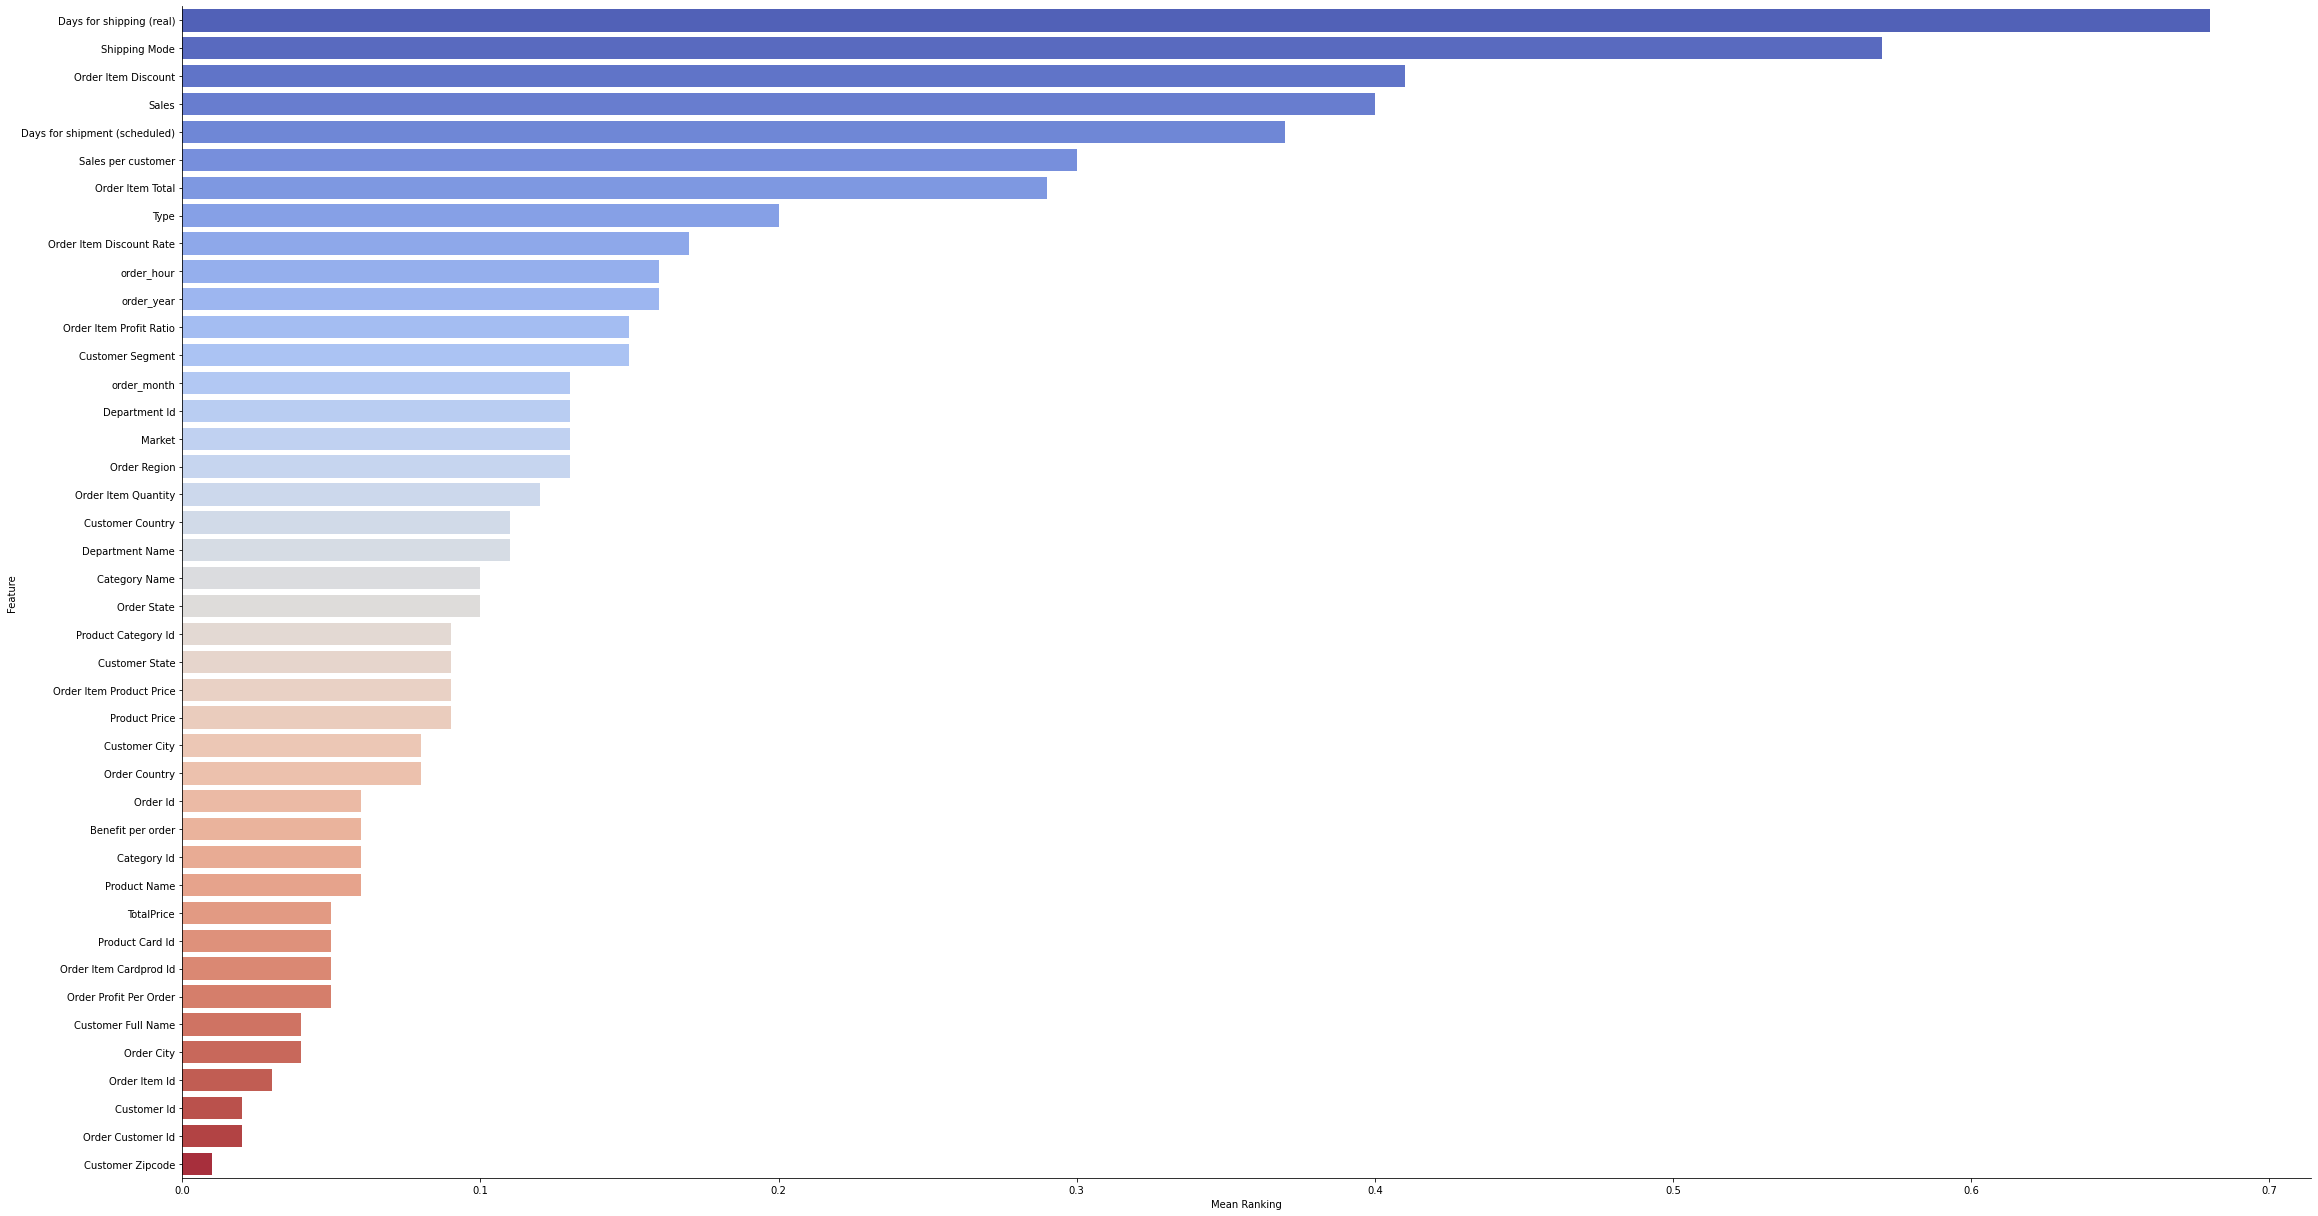

In [ ]:
# Let's plot the ranking of the features
sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", 
               size=17, aspect=1.9, palette='coolwarm')

In [ ]:
a1=['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Category Id',
        'Customer City', 'Customer Country', 'Customer Id',
       'Customer Segment', 'Customer State', 'Customer Zipcode','Department Id','Order City','Order Item Discount', 'Order Item Id', 'Order Item Product Price','Order Item Profit Ratio', 'Order Item Quantity', 'Sales','Order Item Total', 'Order Profit Per Order', 'Order Region','Order State','Product Price', 'Shipping Mode', 'Customer Full Name', 'order_year',
       'order_month', 'order_hour', 'TotalPrice']

In [ ]:
b1=['fraud']

In [ ]:
xf1=train_data[a1]

In [ ]:
yf1=train_data[b1]

In [ ]:
import statsmodels.api as sm
logit_model=sm.Logit(yf1,xf1)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.077772
         Iterations: 35
                               Results: Logit
Model:                  Logit                Pseudo R-squared:     0.277     
Dependent Variable:     fraud                AIC:                  28134.7060
Date:                   2020-07-13 15:33     BIC:                  28417.6065
No. Observations:       180519               Log-Likelihood:       -14039.   
Df Model:               27                   LL-Null:              -19428.   
Df Residuals:           180491               LLR p-value:          0.0000    
Converged:              0.0000               Scale:                1.0000    
No. Iterations:         35.0000                                              
-----------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------
Type                          

In [ ]:
a2=['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Category Id',
        'Customer City', 'Customer Country', 'Customer Id',
       'Customer Segment', 'Customer State', 'Customer Zipcode','Department Id','Order City','Order Item Discount', 'Order Item Id', 'Order Item Product Price','Order Item Profit Ratio', 'Order Item Quantity', 'Sales','Order Item Total', 'Order Profit Per Order', 'Order Region','Order State','Product Price', 'Shipping Mode', 'Customer Full Name', 'order_year',
       'order_month', 'order_hour', 'TotalPrice']

In [ ]:
b2=['late_delivery']

In [ ]:
xl1=train_data[a2]
yl1=train_data[b2]

In [ ]:
import statsmodels.api as sm
logit_model=sm.Logit(yl1,xl1)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.151876
         Iterations 10
                                    Results: Logit
Model:                     Logit                   Pseudo R-squared:        0.779      
Dependent Variable:        late_delivery           AIC:                     54889.0564 
Date:                      2020-07-13 15:33        BIC:                     55171.9569 
No. Observations:          180519                  Log-Likelihood:          -27417.    
Df Model:                  27                      LL-Null:                 -1.2428e+05
Df Residuals:              180491                  LLR p-value:             0.0000     
Converged:                 1.0000                  Scale:                   1.0000     
No. Iterations:            10.0000                                                     
---------------------------------------------------------------------------------------
                               Coef.   Std.Err.     z 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score

Fraud detection

In [ ]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=1, solver='lbfgs',
                         multi_class='multinomial',max_iter=1200000)

# fit the model with data
logreg.fit(xf_train,yf_train)

#
yf_pred=logreg.predict(xf_test)

In [ ]:
print(logreg.coef_)
print(logreg.intercept_)

[[ 3.12260848e+00  5.89088245e-01 -1.31471625e-01  2.88198533e-03
  -1.77997949e-02 -1.14983670e-01 -1.07371263e-02  3.81141309e-02
   3.58863861e-02  2.56881535e-02 -2.60673331e-02  2.15969589e-02
   2.96218422e-03  1.45747764e-02  1.72386893e-03 -8.13195236e-03
  -1.57871815e-02  1.23143743e-03  2.56881535e-02 -2.32642053e-01
   9.02379881e-02 -2.30858894e-02  1.41973266e-02 -8.67016762e-02
   4.36081741e-02 -1.27790343e-02  5.14993655e-02 -1.99524201e-02
  -1.77997949e-02  2.88198533e-03  5.11111853e-02 -8.78448249e-03
   9.02379881e-02 -1.14983670e-01 -3.09040074e-03  4.36081741e-02
  -4.78864745e-01 -4.67759525e-03  3.03073043e-01  7.28394717e-02
   1.75377298e-02 -1.35161458e-02 -2.40066970e+00]]
[-7.38993797]


In [ ]:
cnf_matrix = metrics.confusion_matrix(yf_test, yf_pred)
cnf_matrix

array([[35130,   124],
       [  669,   181]])

Text(0.5, 257.44, 'Predicted label')

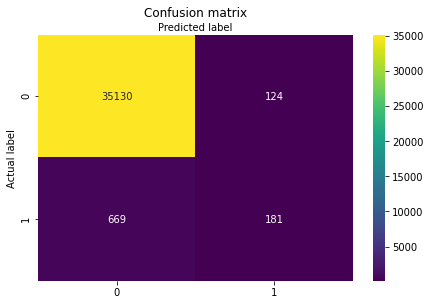

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print(classification_report(yf_test, yf_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     35254
           1       0.59      0.21      0.31       850

    accuracy                           0.98     36104
   macro avg       0.79      0.60      0.65     36104
weighted avg       0.97      0.98      0.97     36104



In [ ]:
print("Accuracy:",metrics.accuracy_score(yf_test, yf_pred))
print("Precision:",metrics.precision_score(yf_test, yf_pred))
print("Recall:",metrics.recall_score(yf_test, yf_pred))

Accuracy: 0.9780356747174829
Precision: 0.5934426229508196
Recall: 0.21294117647058824


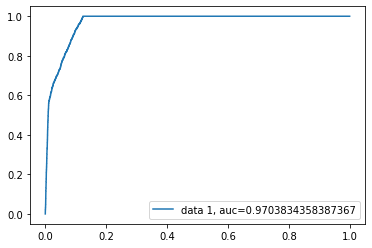

In [ ]:
yf_pred_proba = logreg.predict_proba(xf_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(yf_test,  yf_pred_proba)
auc = metrics.roc_auc_score(yf_test, yf_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
print("Area under curve : ", auc)

Area under curve :  0.9703834358387367


Late delivery detection

In [ ]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=1, solver='lbfgs',
                         multi_class='multinomial',max_iter=1200000)

# fit the model with data
logreg.fit(xl_train,yl_train)

#
yl_pred=logreg.predict(xl_test)

In [ ]:
print(logreg.coef_)
print(logreg.intercept_)

[[-3.72527135e-01  4.95119606e+00 -3.86075747e+00 -5.56734642e-03
  -2.36095137e-02 -6.88203990e-02 -1.03682738e-02  2.45449100e-02
   2.09364545e-02  7.90245346e-03 -5.78310177e-03  8.94965451e-03
   5.01537749e-04  2.77581048e-02  8.34395016e-05 -6.92459698e-04
   1.42759488e-02 -2.43739401e-03  7.90245346e-03 -3.21927741e-01
   5.44060655e-02 -1.37047422e-03 -4.84520346e-03 -1.69895957e-01
   3.51422174e-02  6.04466015e-03  7.96933638e-03 -2.21398144e-02
  -2.36095137e-02 -5.56734642e-03  8.68200202e-03  1.84840772e-04
   5.44060655e-02 -6.88203990e-02  7.08270160e-03  3.51422174e-02
  -5.29922052e-01  9.34735596e-04  4.75111116e-01  1.50748941e-01
   4.63637957e-02  4.04571169e-02 -1.91445371e+00]]
[-0.21388443]


In [ ]:
cnf_matrix = metrics.confusion_matrix(yl_test, yl_pred)
cnf_matrix

array([[15891,   416],
       [    0, 19797]])

Text(0.5, 257.44, 'Predicted label')

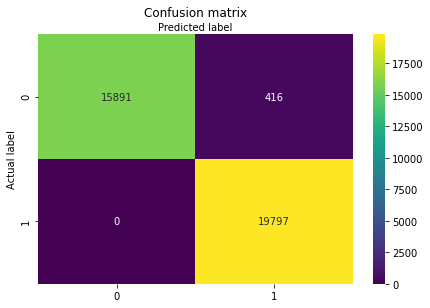

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print(classification_report(yl_test, yl_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     16307
           1       0.98      1.00      0.99     19797

    accuracy                           0.99     36104
   macro avg       0.99      0.99      0.99     36104
weighted avg       0.99      0.99      0.99     36104



In [ ]:
print("Accuracy:",metrics.accuracy_score(yl_test, yl_pred))
print("Precision:",metrics.precision_score(yl_test, yl_pred))
print("Recall:",metrics.recall_score(yl_test, yl_pred))

Accuracy: 0.9884777309993352
Precision: 0.9794191856725869
Recall: 1.0


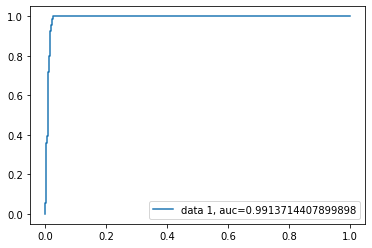

In [ ]:
yl_pred_proba = logreg.predict_proba(xl_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(yl_test,  yl_pred_proba)
auc = metrics.roc_auc_score(yl_test, yl_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
print("Area under curve : ", auc)

Area under curve :  0.9913714407899898
